In [1]:
%load_ext autoreload
%autoreload 2
from srf.models.trifactor import TriFactor
from srf.models.mixed import SymmetricMixed
from srf.models.trifactor_cd import TriFactor as TriFactorCD
from srf.helpers import load_spose_embedding
import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from tools.metrics import compute_similarity
from pathlib import Path
import matplotlib.pyplot as plt
from srf.helpers import (
    best_pairwise_match,
    safe_cross_corr,
)
from joblib import Parallel, delayed
import pandas as pd

def normalize_columns(mat: np.ndarray) -> np.ndarray:
    """
    Z-score each column of mat (subtract mean, divide by sample std).
    """
    means = np.mean(mat, axis=0, keepdims=True)
    stds = np.std(mat, axis=0, ddof=1, keepdims=True)
    return (mat - means) / stds


def greedy_match(embeddings: np.ndarray, spose_embedding: np.ndarray) -> list[tuple[int,int,float]]:
    """
    Greedily match columns of `embeddings` to columns of `spose_embedding` by highest
    Pearson correlation, without replacement.

    Returns:
        List of (emb_idx, spose_idx, corr) sorted by descending corr.
    """
    # Z-score columns
    A_norm = normalize_columns(embeddings)      # shape: (n_samples, n_dims1)
    B_norm = normalize_columns(spose_embedding) # shape: (n_samples, n_dims2)

    n_samples = embeddings.shape[0]
    # Compute correlation matrix: dot of z-scores divided by (n_samples-1)
    corr_matrix = (A_norm.T @ B_norm) / (n_samples - 1)

    # Track available indices
    a_idx = list(range(corr_matrix.shape[0]))  # embedding dims
    b_idx = list(range(corr_matrix.shape[1]))  # spose dims

    matches = []
    # Repeat until one set is exhausted
    while corr_matrix.size:
        # Find max correlation
        i_rel, j_rel = np.unravel_index(np.argmax(corr_matrix), corr_matrix.shape)
        best_corr = corr_matrix[i_rel, j_rel]

        # Map back to original indices
        i_orig = a_idx[i_rel]
        j_orig = b_idx[j_rel]
        matches.append((i_orig, j_orig, best_corr))

        # Remove used row and column
        corr_matrix = np.delete(corr_matrix, i_rel, axis=0)
        corr_matrix = np.delete(corr_matrix, j_rel, axis=1)
        del a_idx[i_rel]
        del b_idx[j_rel]

    # Sort by descending correlation
    matches.sort(key=lambda x: x[2], reverse=True)
    return matches

### Dimension Wise Alignment of the TriFactor model. We can see that without doing the permutation, eg a procrustes transformation having the mixed sign data that is not identity gives bad alignment!

In [17]:
MAX_OBJECTS, MAX_DIMS = 300, 30
spose_embedding = load_spose_embedding(max_objects=MAX_OBJECTS, max_dims=MAX_DIMS)
spose_rsm = compute_similarity(spose_embedding, spose_embedding, "pearson")
spose_rsm -= spose_rsm.min()

max_iter = 5000


model = TriFactorCD(
    init="random_sqrt",
    rank=MAX_DIMS,
    alpha=100.0,
    max_iter=max_iter,
    verbose=True,
    update_a=False,  # important part!
)

w_identity = model.fit_transform(spose_rsm)
history_identity = model.history
frob_identity = history_identity["rec_error"]
corrs_identity = best_pairwise_match(spose_embedding, w_identity)

In [15]:
MAX_OBJECTS, MAX_DIMS = 300, 30
spose_embedding = load_spose_embedding(max_objects=MAX_OBJECTS, max_dims=MAX_DIMS)
spose_rsm = compute_similarity(spose_embedding, spose_embedding, "pearson")

max_iter = 5000

model = TriFactorCD(
    init="random_sqrt",
    rank=MAX_DIMS,
    alpha=100.0,
    max_iter=max_iter,
    verbose=True,
    lam=1.0,
    a_method="fista",
)
w_mixed = model.fit_transform(spose_rsm)
frob_mixed = model.history["rec_error"]
corrs_mixed = best_pairwise_match(spose_embedding, w_mixed)

KeyboardInterrupt: 

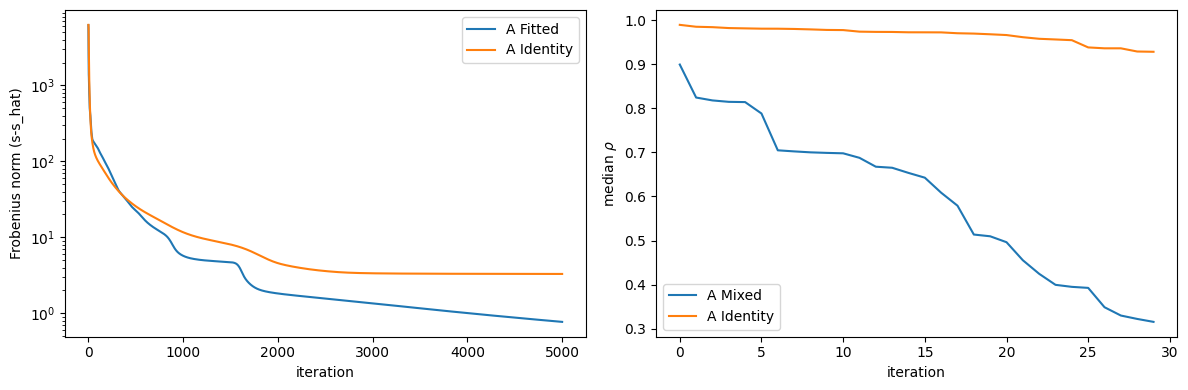

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

max_iter = 5000
sns.lineplot(x=range(max_iter), y=frob_mixed, label="A Fitted", ax=ax1)
sns.lineplot(x=range(max_iter), y=frob_identity, label="A Identity", ax=ax1)
ax1.set_yscale("log")
ax1.set_xlabel("iteration")
ax1.set_ylabel("Frobenius norm (s-s_hat)")
ax1.legend()

sns.lineplot(x=range(len(corrs_mixed)), y=corrs_mixed, label="A Mixed", ax=ax2)
sns.lineplot(x=range(len(corrs_identity)), y=corrs_identity, label="A Identity", ax=ax2)

# ax2.set_ylim(0, 1)
ax2.set_xlabel("iteration")
ax2.set_ylabel("median $\\rho$")
ax2.legend()

plt.tight_layout()
plt.show()

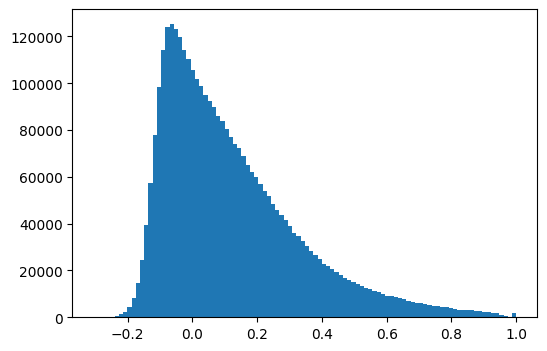

Running grid search over 20 lambda values...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  1.1min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:  3.0min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  4.2min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  4.4min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  4.6min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  4.7min remaining:   31.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.1min finished


Text(0.5, 1.0, 'Mean Correlation vs Lambda')

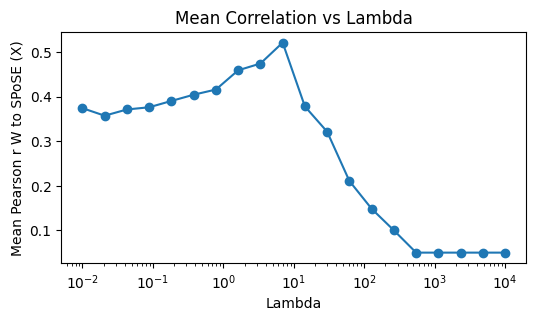

In [17]:
# Load the data
MAX_OBJECTS, MAX_DIMS = 1854, 66
spose_embedding = load_spose_embedding(max_objects=MAX_OBJECTS, max_dims=MAX_DIMS)
spose_rsm = compute_similarity(spose_embedding, spose_embedding, "pearson")

plt.figure(figsize=(6, 4))
plt.hist(spose_rsm.flatten(), bins=100)
plt.show()

# # Define the grid of lambda values to search
lambda_values = np.logspace(-2, 4, 20)  # 20 values from 0.01 to 100


def evaluate_lambda(lam_value):
    """Evaluate a single lambda value and return metrics."""
    model = TriFactorCD(
        init="random_sqrt",
        rank=MAX_DIMS,
        alpha=100.0,
        max_iter=1000,
        update_a=True,
        verbose=False,  # Set to False to avoid too much output
        lam=lam_value,
        cd_inner=100,
        random_state=1,
        a_method="fista",
    )

    w_fitting = model.fit_transform(spose_rsm)
    history_fitting = model.history
    frob_fitting = history_fitting["rec_error"][-1]  # Get final reconstruction error
    corrs_fitting = best_pairwise_match(spose_embedding, w_fitting)

    return {
        "lambda": lam_value,
        "reconstruction_error": frob_fitting,
        "rec_error": history_fitting["rec_error"],
        "mean_correlation": np.mean(corrs_fitting),
        "min_correlation": np.min(corrs_fitting),
        "max_correlation": np.max(corrs_fitting),
        "corrs": corrs_fitting,
    }


# Run the grid search in parallel
print(f"Running grid search over {len(lambda_values)} lambda values...")
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(evaluate_lambda)(lam) for lam in lambda_values
)

# Convert results to DataFrame
results_df = pd.DataFrame(results)


plt.figure(figsize=(6, 3))
plt.semilogx(results_df["lambda"], results_df["mean_correlation"], "o-")
plt.xlabel("Lambda")
plt.ylabel("Mean Pearson r W to SPoSE (X)")
plt.title("Mean Correlation vs Lambda")

Best lambda: 100.0


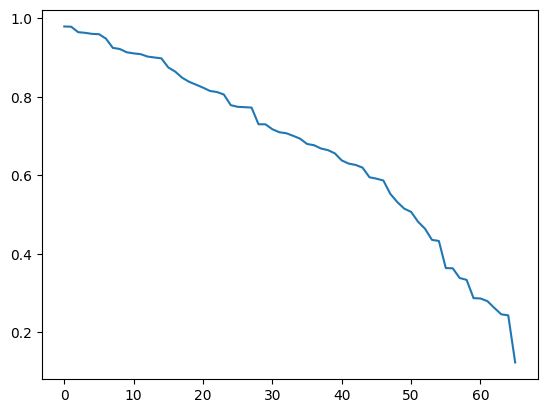

In [ ]:
# get the best lambda
best_lambda = results_df.loc[results_df["mean_correlation"].idxmax()]["lambda"]
print(f"Best lambda: {best_lambda}")

# get the corrs for the best lambda
corrs = results_df.loc[results_df["lambda"] == best_lambda]["corrs"].values[0]
plt.plot(corrs)
plt.show()

In [15]:
model.a_

array([[ 0.03379396, -0.00427964,  0.00958572, ..., -0.01039157,
        -0.01128505, -0.00316181],
       [-0.00428219,  0.06947672,  0.00210656, ..., -0.01225058,
         0.0054396 ,  0.00152311],
       [ 0.0095858 ,  0.0021147 ,  0.06170354, ...,  0.02511988,
        -0.00302416, -0.0068912 ],
       ...,
       [-0.01039627, -0.01224675,  0.02511441, ...,  0.06357095,
         0.03367952, -0.00084556],
       [-0.01129277,  0.00544503, -0.00302644, ...,  0.03368214,
         0.10594137, -0.00396174],
       [-0.00316363,  0.00152587, -0.00689182, ..., -0.00084297,
        -0.00396153,  0.04934277]], shape=(66, 66))

Running grid search over 20 lambda values...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    2.2s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    3.2s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    3.6s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    3.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    3.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    5.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.7s finished


Text(0.5, 1.0, 'Mean Correlation vs Lambda')

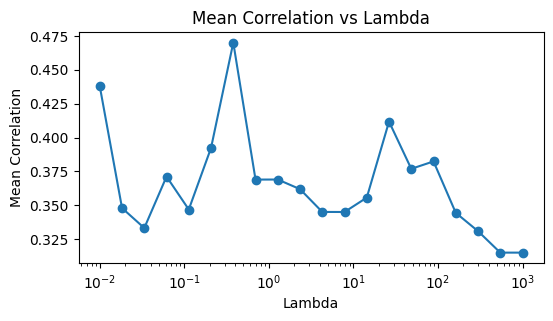

In [54]:
n = 100
k = 10

W0 = np.abs(np.random.randn(n, k))
H0 = W0.copy()
A0 = np.eye(k) + 0.3 * (np.random.rand(k, k) * (np.random.rand(k, k) < 0.2))
S = W0 @ A0 @ H0.T


# # Define the grid of lambda values to search
lambda_values = np.logspace(-2, 3, 20)  # 20 values from 0.01 to 100


def evaluate_lambda(lam_value):
    """Evaluate a single lambda value and return metrics."""
    model = TriFactorCD(
        init="random",
        rank=k,
        alpha=100.0,
        max_iter=1000,
        update_a=True,
        verbose=False,  # Set to False to avoid too much output
        lam=lam_value,
        cd_inner=100,
        random_state=1,
    )

    w_fitting = model.fit_transform(S)
    history_fitting = model.history
    frob_fitting = history_fitting["rec_error"][-1]  # Get final reconstruction error
    corrs_fitting = best_pairwise_match(W0, w_fitting)

    return {
        "lambda": lam_value,
        "reconstruction_error": frob_fitting,
        "rec_error": history_fitting["rec_error"],
        "mean_correlation": np.mean(corrs_fitting),
        "min_correlation": np.min(corrs_fitting),
        "max_correlation": np.max(corrs_fitting),
    }


# Run the grid search in parallel
print(f"Running grid search over {len(lambda_values)} lambda values...")
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(evaluate_lambda)(lam) for lam in lambda_values
)

# Convert results to DataFrame
results_df = pd.DataFrame(results)


plt.figure(figsize=(6, 3))
plt.semilogx(results_df["lambda"], results_df["mean_correlation"], "o-")
plt.xlabel("Lambda")
plt.ylabel("Mean Correlation")
plt.title("Mean Correlation vs Lambda")

In [ ]:
from srf.models.trifactor_cd import TriFactor as TriFactorCD
from srf.models.trifactor import TriFactor


# ------ Test on synthetic data ------
# np.random.seed(42)
# n, k = 40, 5
# W_true = np.abs(np.random.randn(n, k))
# H_true = np.abs(np.random.randn(n, k))
# A_true = np.zeros((k, k))
# A_true[np.random.choice(k, 5), np.random.choice(k, 5)] = np.random.randn(5)
# S = W_true @ (A_true + np.eye(k)) @ H_true.T + 0.05 * np.random.randn(n, n)

n_samples = 1854
rank = 66
rng = np.random.default_rng(1)
X_true = load_spose_embedding(max_objects=n_samples, max_dims=rank)
# S_true = X_true @ X_true.T
# S_true /= S_true.max()

S = np.corrcoef(X_true)


# W_est, A_est, H_est, obj_curve = tri_factor_cd(
#     S_true, rank, alpha=100.0, gamma=1e-2, max_outer=100, tol=1e-6
# )

model = TriFactorCD(
    rank=rank,
    init="random_sqrt",
    alpha=1.0,
    lam=100.0,
    max_iter=600,
    cd_inner=100,
    tol=1e-6,
    verbose=True,
)

w = model.fit_transform(S)
corrs = best_pairwise_match(X_true, w)
plt.plot(corrs)

Generating membership matrix with 30 samples and 5 clusters


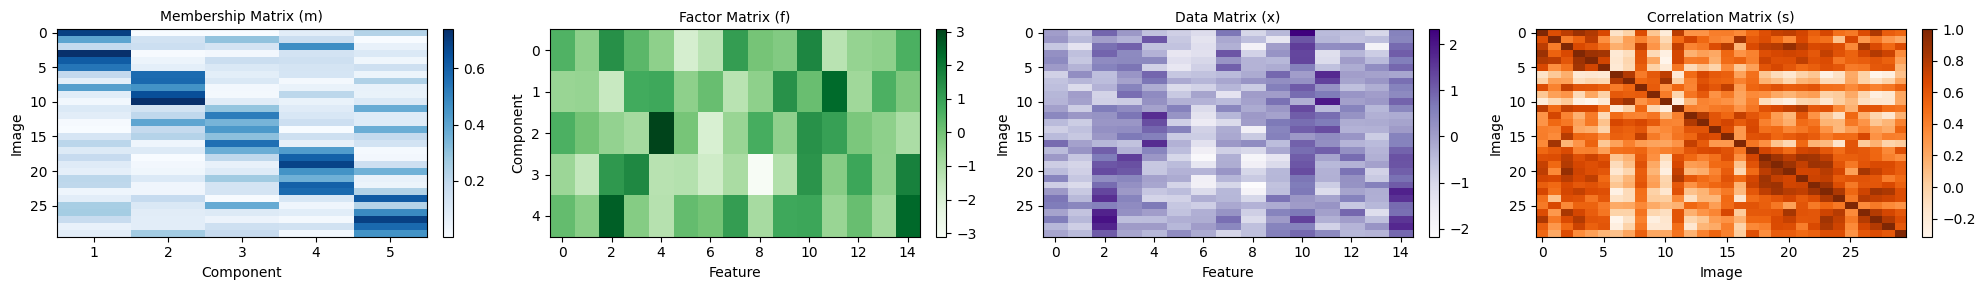

In [121]:
from srf.simulation import SimulationParams, generate_simulation_data
from srf.plotting import plot_simulation


params = SimulationParams()
params.n = 30
params.p = 15
params.primary_concentration = 5.0
params.k = 5
params.snr = 0.7

x, m, f, s = generate_simulation_data(params)
fig = plot_simulation(x, m, f, s)

(array([  17244.,  798874., 1013734.,  700926.,  427286.,  229256.,
         124076.,   70170.,   38090.,   17660.]),
 array([-0.3053407 , -0.17480663, -0.04427256,  0.08626151,  0.21679558,
         0.34732965,  0.47786372,  0.60839779,  0.73893186,  0.86946593,
         1.        ]),
 <BarContainer object of 10 artists>)

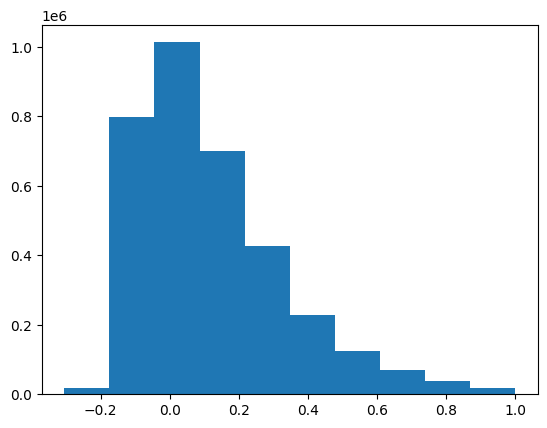

In [167]:
S = np.corrcoef(X_true)
plt.hist(S.flatten())

Generating membership matrix with 100 samples and 10 clusters


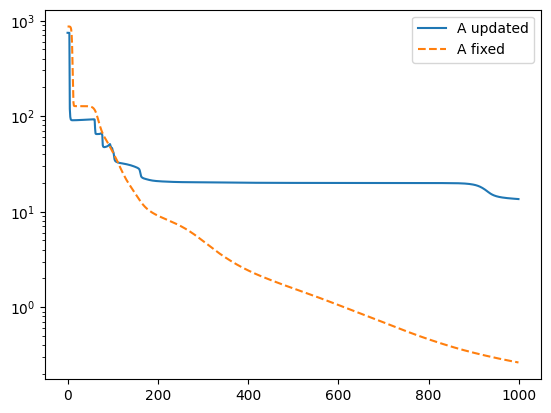

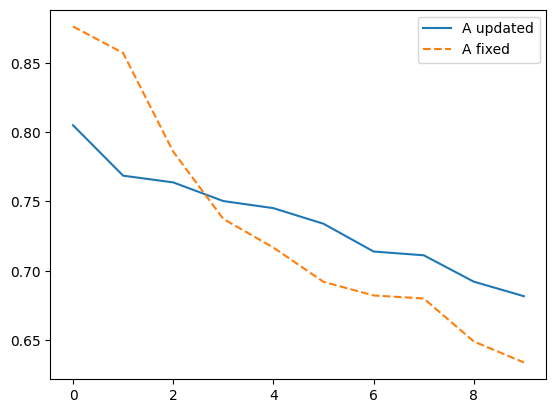

In [166]:
from srf.simulation import SimulationParams, generate_simulation_data

params = SimulationParams()
params.n = 100
params.p = 100
params.primary_concentration = 5.0
params.k = 10
params.snr = 1.0

x, m, f, s = generate_simulation_data(params)


model = TriFactorCD(
    rank=params.k,
    init="random",
    alpha=100.0,
    lam=0.1,
    max_iter=1000,
    update_a=True,
    cd_inner=100,
)

w_mixed = model.fit_transform(s)
obj_mixed = model.history["rec_error"]
model.update_a = False

s_pos = s - s.min()
w_fixed = model.fit_transform(s_pos)
obj_fixed = model.history["rec_error"]

plt.semilogy(obj_mixed, label="A updated")
plt.semilogy(obj_fixed, label="A fixed", ls="--")
plt.legend()
plt.show()

corrs_mixed = best_pairwise_match(x, w_mixed)
corrs_fixed = best_pairwise_match(x, w_fixed)

plt.plot(corrs_mixed, label="A updated")
plt.plot(corrs_fixed, label="A fixed", ls="--")
plt.legend()
plt.show()

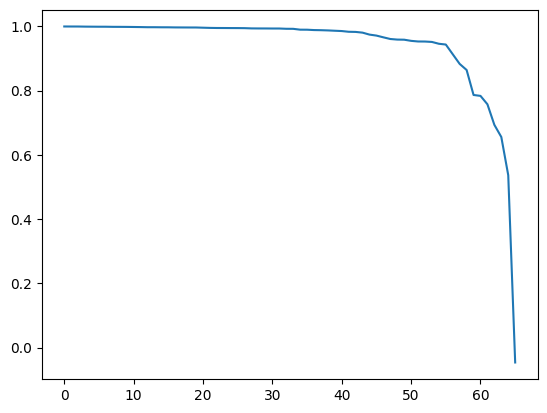

In [108]:
corrs = best_pairwise_match(X_true, w)
plt.plot(corrs)

In [4]:
def synthetic_corr(n=80, r=8, seed=1, eps=1e-12):
    rng = np.random.default_rng(seed)
    W = rng.random((n, r))
    L = rng.standard_normal((r, r))
    A = L @ L.T + eps * np.eye(r)  # +eps·I to improve conditioning
    S = W @ A @ W.T
    # now normalize so that S[i,i] == 1 for all i
    d = np.sqrt(np.diag(S))
    S = S / (d[:, None] @ d[None, :])
    return W, A, S


n, r = 1854, 66
max_iter = 500
rng = np.random.default_rng(1)
X_true = load_spose_embedding(max_objects=n, max_dims=r)
S_true = X_true @ X_true.T
S_true /= S_true.max()

model = TriFactorADMM(
    rank=66,
    max_outer=max_iter,
    verbose=True,
    lam=1.0,
    beta=100,
)
w = model.fit_transform(S_true)

corrs = best_pairwise_match(X_true, w)
plt.plot(corrs)

KeyboardInterrupt: 

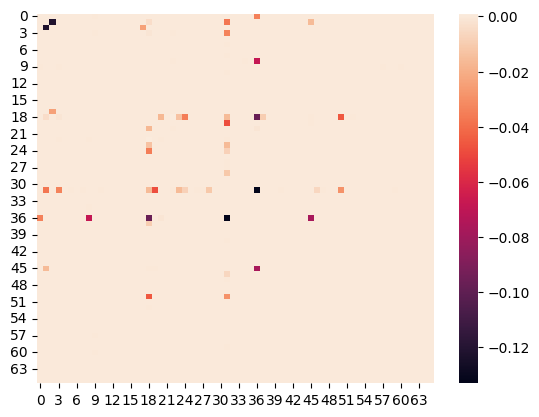

In [10]:
a = model.a_
np.fill_diagonal(a, 0)
sns.heatmap(model.a_)
plt.show()

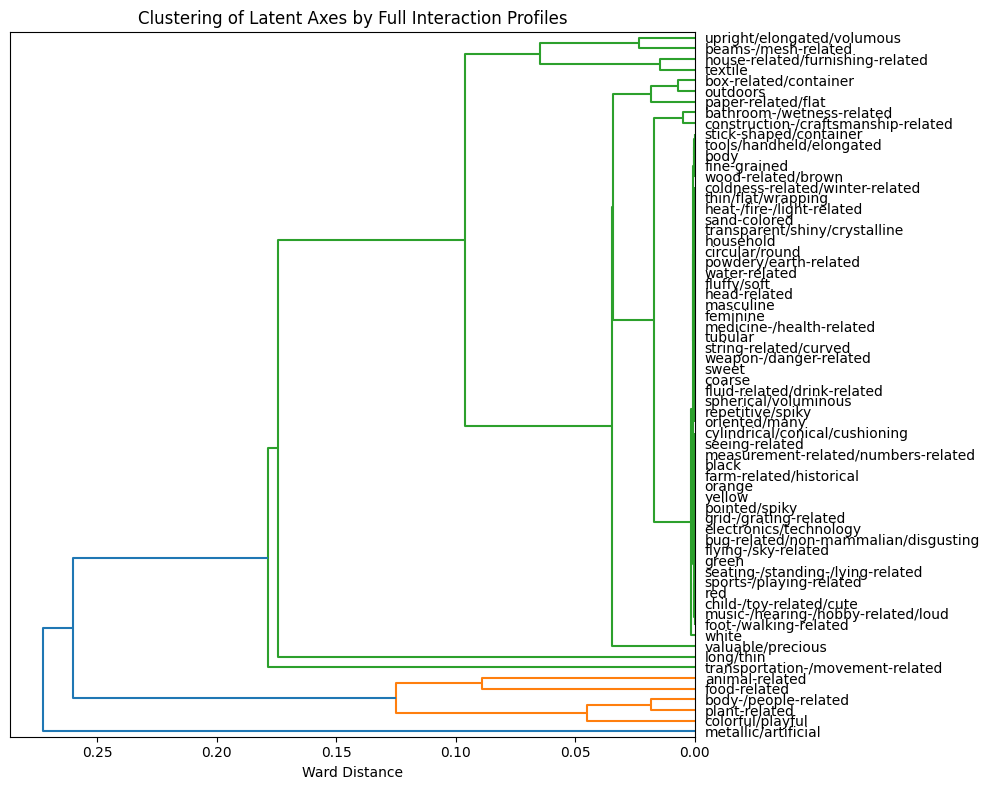

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform


# 1) Greedy match code (unchanged)
def normalize_columns(mat):
    means = mat.mean(0, keepdims=True)
    stds = mat.std(0, ddof=1, keepdims=True)
    return (mat - means) / stds


def greedy_match(emb, spose):
    A = normalize_columns(emb)
    B = normalize_columns(spose)
    n = emb.shape[0]
    C = (A.T @ B) / (n - 1)
    a_idx = list(range(C.shape[0]))
    b_idx = list(range(C.shape[1]))
    matches = []
    while C.size:
        i, j = divmod(C.argmax(), C.shape[1])
        matches.append((a_idx[i], b_idx[j], C[i, j]))
        C = np.delete(np.delete(C, i, 0), j, 1)
        del a_idx[i], b_idx[j]
    return matches


# assume w (n×r), X_true (n×r), model.a_ (r×r), and labels (r-list) are in scope:
matches = greedy_match(w, X_true)
labels = np.loadtxt("../data/misc/labels_spose_66d_short.txt", dtype=str, usecols=0)

# 2) Sort by SPoSE‐index so that your axes line up to the SPoSE ordering
matches_by_spose = sorted(matches, key=lambda tpl: tpl[1])
learn_idxs = [i for i, _, _ in matches_by_spose]
labels_sorted = [labels[j] for _, j, _ in matches_by_spose]

# 3) Sort A and also build the feature‐matrix for clustering
A = model.a_  # r×r
A_sorted = A[np.ix_(learn_idxs, learn_idxs)]  # reorder both axes

# We'll cluster on each row of A_sorted (the full interaction profile):
features = A_sorted.copy()
np.fill_diagonal(features, 0)  # zero out self‐interaction

# 4) Compute pairwise distances between rows
#    You can use 'euclidean' or 'correlation' to capture profile‐shape similarity
D = pdist(features, metric="euclidean")
Z = linkage(D, method="ward")

# 5) Plot dendrogram
plt.figure(figsize=(10, 8))
dendrogram(
    Z,
    labels=labels_sorted,
    orientation="left",
    leaf_font_size=10,
    color_threshold=0.7 * max(Z[:, 2]),
)
plt.title("Clustering of Latent Axes by Full Interaction Profiles")
plt.xlabel("Ward Distance")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import lsq_linear
from collections import defaultdict
from srf.models.mixed import SymmetricMixed
from tools.metrics import compute_similarity


# --------------------------------------------------------------------------- #
#  Small helper – one bounded–NNLS row                                        #
# --------------------------------------------------------------------------- #
def _bounded_nnls_row(A, b, lb, ub, eps=1e-12):
    """
    Solve  min_x ‖A x − b‖₂        s.t. lb ≤ x ≤ ub    (element-wise).

    A  : (m, r)   design matrix     (float64)
    b  : (m,)     right-hand side   (float64)
    lb : (r,)     lower bounds      (≥ 0)
    ub : (r,)     upper bounds      (≥ lb)

    Any entry of ub < lb is pushed up to lb + eps.
    """
    lb = np.maximum(lb, 0.0)
    ub = np.maximum(ub, lb + eps)
    res = lsq_linear(A, b, bounds=(lb, ub), method="trf")
    return res.x


# --------------------------------------------------------------------------- #
#  Symmetric mixed NMF with *both* factors via bounded NNLS                   #
# --------------------------------------------------------------------------- #
def symmetric_mixed_nmf(
    S: np.ndarray,
    rank: int,
    max_iter: int = 500,
    tol: float = 1e-6,
    random_state: int | None = None,
):
    r"""
    Factorise S (symmetric) as  S ≈ W_pos W_posᵀ − W_neg W_negᵀ,  with

        0 ≤ W_neg ≤ W_pos.

    Updates use Alternating NNLS (row-wise, bounded).

    Returns
    -------
    W_pos, W_neg, err_history, norms         (all np.ndarrays)
    """
    if S.shape[0] != S.shape[1]:
        raise ValueError("S must be square / symmetric")
    n = S.shape[0]
    rng = np.random.default_rng(random_state)

    # ---------- initialise --------------------------------------------------
    W_pos = rng.random((n, rank))
    W_neg = rng.random((n, rank)) * 0.5  # safely below W_pos

    err_prev = np.inf
    hist, norms = [], defaultdict(list)

    # ---------- main loop ---------------------------------------------------
    for it in range(1, max_iter + 1):
        # ---- (1) update W_pos  -------------------------------------------
        Z_pos = S + W_neg @ W_neg.T  # target for the + part
        for i in range(n):
            W_pos[i] = _bounded_nnls_row(
                A=W_pos,  # (n × r) design matrix
                b=Z_pos[i],  # (n,)
                lb=W_neg[i],  # lower bound = W_neg row
                ub=np.full(rank, np.inf),  # no upper bound
            )

        # ---- (2) update W_neg  -------------------------------------------
        Z_neg = W_pos @ W_pos.T - S  # target for the – part
        for i in range(n):
            W_neg[i] = _bounded_nnls_row(
                A=W_neg,  # (n × r)
                b=Z_neg[i],
                lb=np.zeros(rank),  # ≥ 0
                ub=W_pos[i],  # upper bound = W_pos row
            )

        # ---- (3) bookkeeping & stopping -----------------------------------
        R = W_pos @ W_pos.T - W_neg @ W_neg.T - S
        err = np.linalg.norm(R, "fro")
        hist.append(err)
        norms["pos"].append(np.linalg.norm(W_pos, "fro"))
        norms["neg"].append(np.linalg.norm(W_neg, "fro"))

        print(f"iter {it:4d}   err={err:.3f}", end="\r")

    return W_pos, W_neg, np.asarray(hist), norms


def symmetric_mixed_nmf_projective(
    S: np.ndarray,
    rank: int,
    max_iter: int = 500,
    eta: float | None = None,
    tol: float = 1e-6,
    enforce_feasible: bool = True,
    random_state: int | None = None,
):
    """
    Decompose a symmetric matrix S ≈ W_pos W_pos.T - W_neg W_neg.T
    with non-negative (n x r) factors.  Very small, pure-function
    implementation – no external dependencies except NumPy.

    Returns
    -------
    W_pos, W_neg, history   (history holds Frobenius error per iter)
    """
    if S.shape[0] != S.shape[1]:
        raise ValueError("S must be square / symmetric")
    n = S.shape[0]
    rng = np.random.default_rng(random_state)

    # ---- initialisation ---------------------------------------------------
    W_pos = rng.random((n, rank))
    W_neg = rng.random((n, rank)) * 0.5  # start smaller, purely heuristic

    if eta is None:
        # safe spectral-norm based stepsize
        eta = 1.0 / (np.linalg.norm(S, 2) + 1.0)

    err_prev = np.inf
    hist = []
    norms = defaultdict(list)

    # ---- main loop ---------------------------------------------------------
    for it in range(1, max_iter + 1):
        R = W_pos @ W_pos.T - W_neg @ W_neg.T - S  # residual

        # gradient steps + projection
        W_pos -= eta * (R @ W_pos)
        W_neg += eta * (R @ W_neg)
        np.maximum(W_pos, 0.0, out=W_pos)
        np.maximum(W_neg, 0.0, out=W_neg)

        if enforce_feasible:
            mask = W_neg > W_pos
            W_neg[mask] = W_pos[mask]

        # convergence check
        err = np.linalg.norm(R, "fro")
        hist.append(err)
        norms["pos"].append(np.linalg.norm(W_pos, "fro"))
        norms["neg"].append(np.linalg.norm(W_neg, "fro"))

        print(f"iter {it:4d}   err={err:.3f}", end="\r")

    return W_pos, W_neg, np.asarray(hist), norms


def synthetic_positive(n=80, r=8, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.random((n, r))
    S = W @ W.T
    S = (S + S.T) / 2
    return S


def synthetic_mixed(n=80, r=8, seed=1):
    rng = np.random.default_rng(seed)
    Wp = rng.random((n, r))
    Wn = 0.7 * rng.random((n, r))
    S = Wp @ Wp.T - Wn @ Wn.T
    S = (S + S.T) / 2
    return S


# Synthetic demo data  (300×20)
# ------------------------------------------------------------------
n_samples = 1854
rank = 66
rng = np.random.default_rng(1)
# X_true = load_spose_embedding(max_objects=n_samples, max_dims=rank)
# S = X_true @ X_true.T
# S /= S.max()

# ground‑truth latent factors (non‑negative just for demo)
n, r = 50, 5


# S_true = synthetic_mixed(n, r)
S_true = synthetic_positive(n, r)


model = SymmetricMixed(
    init="random",
    rank=rank,
    max_iter=1000,
    verbose=True,
    projection_step=False,
    alpha=10.0,
    tol=0.0,
    normalize_factors=True,
)
model.fit(S_true)

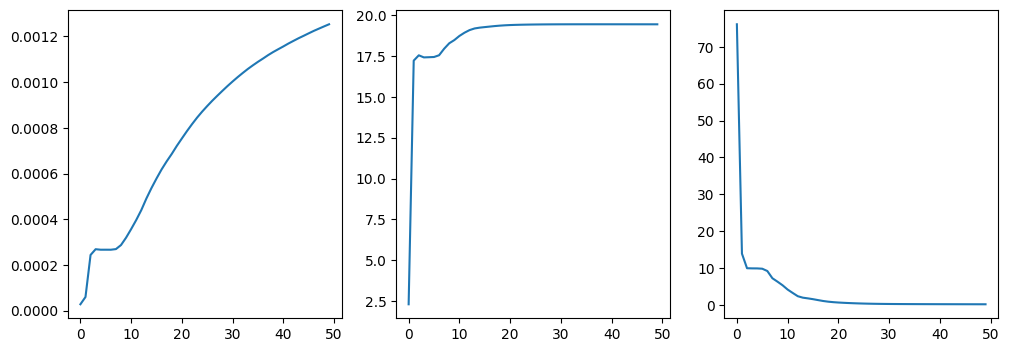

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(model.history["neg_mass"])
ax[1].plot(model.history["pos_mass"])
ax[2].plot(model.history["obj"])

In [96]:
import numpy as np
from scipy.optimize import nnls


def symmetric_mixed_admm_nnls(
    S: np.ndarray,
    rank: int,
    alpha: float | None = None,
    rho: float | None = None,
    max_iter: int = 200,
    tol: float = 1e-6,
    random_state: int | None = None,
    verbose: bool = False,
):
    """
    Symmetric mixed-sign NMF via ADMM + standard NNLS (no CD).

    Solves
        min_{W+,W-,H+,H- >= 0} ||S - (W+ H+^T - W- H-^T)||_F^2
        s.t. W- <= W+,  H- <= H+
    by splitting the box-constraints into auxiliary vars and alternating:

      1) NNLS updates for (W-, H-) with augmented terms
      2) closed-form updates for (W+, H+) + nonneg clamp
      3) simple elementwise projection for aux vars Z,J
      4) dual ascent on U,V

    Returns
    -------
    Wp, Wn, Hp, Hn : np.ndarray, shapes (n, rank)
        The nonnegative factors.
    history : dict[str, list]
        'obj'        reconstruction error ‖S - (Wp Hp^T - Wn Hn^T)‖_F
        'pri_res'    ADMM primal residual
        'dual_res'   ADMM dual   residual
    """
    n = S.shape[0]
    if alpha is None:
        alpha = float(np.max(np.abs(S))) ** 2
    if rho is None:
        rho = alpha

    rng = np.random.default_rng(random_state)
    # primal vars
    Wp = rng.random((n, rank))
    Hp = Wp.copy()
    Wn = 0.1 * rng.random((n, rank))
    Hn = Wn.copy()
    # aux & dual
    Z = Wn.copy()
    J = Hn.copy()
    U = np.zeros_like(Wn)
    V = np.zeros_like(Hn)

    I_r = np.eye(rank)
    history = {"obj": [], "pri_res": [], "dual_res": []}
    Z_prev, J_prev = Z.copy(), J.copy()

    for it in range(1, max_iter + 1):
        # 1) Negative-block NNLS with augmented term
        Zneg = Wp @ Hp.T - S  # residual
        sqrt_a, sqrt_r = np.sqrt(alpha), np.sqrt(rho)

        # build stacked A-matrices once
        A_w = np.vstack([Hn, sqrt_a * I_r, sqrt_r * I_r])  # (r + r + r)×r
        A_h = np.vstack([Wp, sqrt_a * I_r, sqrt_r * I_r])

        # update W-
        for i in range(n):
            b_w = np.concatenate(
                [
                    -Zneg[i],  # from data fit
                    sqrt_a * Hn[i],  # symmetry penalty
                    sqrt_r * (Z[i] - U[i]),  # ADMM aug term
                ]
            )
            Wn[i], _ = nnls(A_w, b_w)

        # update H-
        ZnegT = Zneg.T
        for i in range(n):
            b_h = np.concatenate([-ZnegT[i], sqrt_a * Wn[i], sqrt_r * (J[i] - V[i])])
            Hn[i], _ = nnls(A_h, b_h)

        # 2) Positive-block closed-form + clamp
        Zpos = S + Wn @ Hn.T
        M1 = Hp.T @ Hp + alpha * I_r
        invM1 = np.linalg.inv(M1)
        Wp = np.clip(Zpos @ Hp @ invM1, 0, None)

        M2 = Wp.T @ Wp + alpha * I_r
        invM2 = np.linalg.inv(M2)
        Hp = np.clip(Zpos.T @ Wp @ invM2, 0, None)

        # 3) Aux projections
        Z = np.clip(Wn + U, 0, Wp)
        J = np.clip(Hn + V, 0, Hp)

        # 4) Dual updates
        U += Wn - Z
        V += Hn - J

        # diagnostics
        S_hat = Wp @ Hp.T - Wn @ Hn.T
        err = np.linalg.norm(S - S_hat, "fro")
        pri = np.linalg.norm(Wn - Z, "fro") + np.linalg.norm(Hn - J, "fro")
        dual = rho * (
            np.linalg.norm(Z - Z_prev, "fro") + np.linalg.norm(J - J_prev, "fro")
        )

        history["obj"].append(err)
        history["pri_res"].append(pri)
        history["dual_res"].append(dual)

        if verbose and it % 1 == 0:
            print(f"iter {it:3d}  err {err:.3f}  pri {pri:.3f}  dual {dual:.3f}")

        # check ADMM convergence
        if pri < tol and dual < tol:
            break

        Z_prev[:] = Z
        J_prev[:] = J

    return Wp, Wn, Hp, Hn, history


# synthetic mixed-sign data
n, r = 1854, 66
rng = np.random.default_rng(0)
# Wp_true = rng.random((n, r))
# Wn_true = 0.3 * rng.random((n, r))
# S = Wp_true @ Wp_true.T - Wn_true @ Wn_true.T
# S = (S + S.T) / 2
X_true = load_spose_embedding(max_objects=n, max_dims=r)
S = X_true @ X_true.T
S = S / S.max()


Wp, Wn, Hp, Hn, hist = symmetric_mixed_admm_nnls(
    S,
    rank=r,
    alpha=None,
    rho=None,
    max_iter=1000,
    tol=0.0,
    random_state=42,
    verbose=True,
)

print("final error:", hist["obj"][-1])

iter   1  err 121.436  pri 0.000  dual 40.410
iter   2  err 175.925  pri 2.590  dual 24.267
iter   3  err 139.798  pri 4.122  dual 27.848
iter   4  err 121.216  pri 2.168  dual 2.514
iter   5  err 110.519  pri 1.402  dual 1.766
iter   6  err 103.461  pri 0.957  dual 1.257
iter   7  err 96.625  pri 0.708  dual 0.926
iter   8  err 88.965  pri 0.578  dual 0.815
iter   9  err 80.925  pri 0.613  dual 0.728
iter  10  err 73.229  pri 0.621  dual 0.610
iter  11  err 66.067  pri 0.632  dual 0.615
iter  12  err 59.531  pri 0.587  dual 0.552
iter  13  err 53.285  pri 0.565  dual 0.537
iter  14  err 46.841  pri 0.543  dual 0.568
iter  15  err 41.336  pri 0.552  dual 0.618
iter  16  err 37.301  pri 0.445  dual 0.591
iter  17  err 34.228  pri 0.347  dual 0.443
iter  18  err 31.785  pri 0.286  dual 0.345
iter  19  err 29.828  pri 0.240  dual 0.289
iter  20  err 28.273  pri 0.216  dual 0.238
iter  21  err 27.042  pri 0.196  dual 0.205
iter  22  err 26.046  pri 0.172  dual 0.184
iter  23  err 25.219  p

KeyboardInterrupt: 

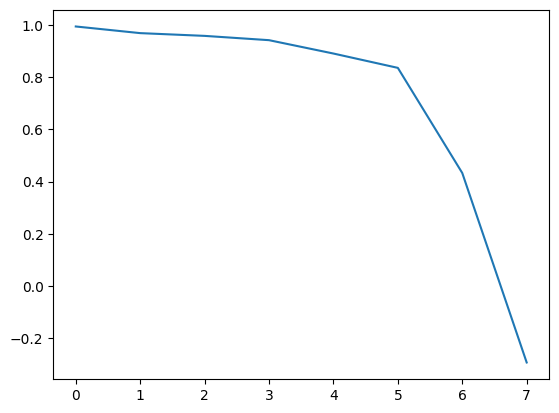

In [ ]:
W = Wp - Wn
corrs = best_pairwise_match(W, X_true)
plt.plot(corrs)